# Report Simulations and Figures

In [1]:
### PACKAGES ###
import math, matplotlib, random
import numpy as np 
from scipy.stats import norm
import statistics as stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Severity Model ($z$)

In [2]:
### LISTS TO STORE DICTIONARIES ###
pm = []        # All parameters
best_pm = []     # Best parameters for each p value


### PARAMETERS ###
Smean=0; Svar=1; Sstd=math.sqrt(Svar)       # Safe environment
Imean=1.5; Ivar=1; Istd=math.sqrt(Ivar)     # Infected environment
delta=0.05                                  # Background mortatility (delta)

# Probability that the environment is infected (p)
p_range=np.arange(0.1, 1, 0.1).tolist()
p_list=[round(p, 2) for p in p_range]

# Threshold range (within three standard deviations to get 99.73% of all values) 
Slower = Smean - (3 * Sstd)
Iupper = Imean + (3 * Istd)
threshold_range=np.arange(Slower, Iupper+0.01, 0.01).tolist()
thresholds=[round(t, 2) for t in threshold_range]

# Probability that the situation is severe 
z_range=np.arange(0, 1.2, 0.2).tolist()
z_list=[round(z, 2) for z in z_range]


### SIMULATION ##
iteration = -1  # Row index counter

### ITERATION OVER EVERY SEVERITY PROBABILITY (z) ###
for z in z_list:
    
    ### ITERATION OVER EVERY PROBABILITY OF THE ENVIRONMENT BEING INFECTED (p) ###
    for p in p_list:
        theta_max = best_threshold = 0
        bp = {'index' : iteration, 'z' : z, 'p' : p, 'theta_max' : theta_max, 'threshold' : best_threshold}

        ### ITERATING OVER EVERY THRESHOLD ###
        for threshold in thresholds:
            iteration = iteration + 1

            ### PROBABILITY AREAS ###
            # Calculate z-score for each environment distribution
            Sz = stats.NormalDist(Smean, Sstd).zscore(threshold)
            Iz = stats.NormalDist(Imean, Istd).zscore(threshold)

            # Calculate probability from z-score based on threshold
            Sprob = norm.cdf(Sz)
            Iprob = norm.cdf(Iz)

            # Calculate the specific area of the distributions scaled to the probability of the environment being infected (p)
            p_iw = Iprob * p
            p_ih = (1 - Iprob) * p
            p_sh = (1 - Sprob) * (1 - p)
            p_sw = Sprob * (1 - p)

            ### SHORT-TERM PARAMETERS ###
            a = (1-delta) * ((p_iw * (1-z)) + (p_ih * z) + (p_sh * z))       # Probability of losing a reserve
            b = (1-delta) * p_sw                                # Probability of gaining a reserve
            c = (1-delta) * ((p_ih * (1-z)) + (p_sh * (1-z)))           # Probability of remaining at the same reserve level
            death = 1 - a - b - c                               # Probability of death while trying to gain a reserve

            ### LONG-TERM PROBABILITY (theta) ###
            # Parameters for quadratic formula
            qf_a = float(a)
            qf_b = float(c - 1)
            qf_c = float(b)

            # Calculate theta
            theta = (-(qf_b) - math.sqrt((pow(qf_b, 2) - (4 * qf_a * qf_c)))) / (2 * qf_a)

            ### DICTIONARY OF PARAMETERS ###
            pm.append(
                {
                    'p' : p,
                    'z' : z,
                    'threshold' : threshold,
                    'a' : a, 'b' : b, 'c' : c,      # Short-term probability
                    'theta' : theta,                # Long-term probability
                    'd' : death,                    # Residual death
                }
            )

            # Identifying the threshold associated with the largest long-term probability of gaining a reserve (theta)
            if theta > bp['theta_max']:
                bp['index'] = iteration
                bp['z'] = z
                bp['p'] = p
                bp['theta_max'] = theta
                bp['threshold'] = threshold

        ### SAVE THE BEST PARAMETERS FOR EVERY p ###
        best_pm.append(bp)

## DataFrames

In [3]:
df_pm = pd.DataFrame(pm)
df_best_pm = pd.DataFrame(best_pm)

## Figure 4: Severity probability

**(A)** Largest long-term probability of eventually gaining a reserve unit ($\theta_{max}$) across increasing probabilities of environmental infection ($p$) hued by six unique severity parameters ($z$). 

**(B)** Optimal threshold ($x_T$) across increasing probabilities of environmental infection ($p$)
hued by six unique severity parameters ($z$).

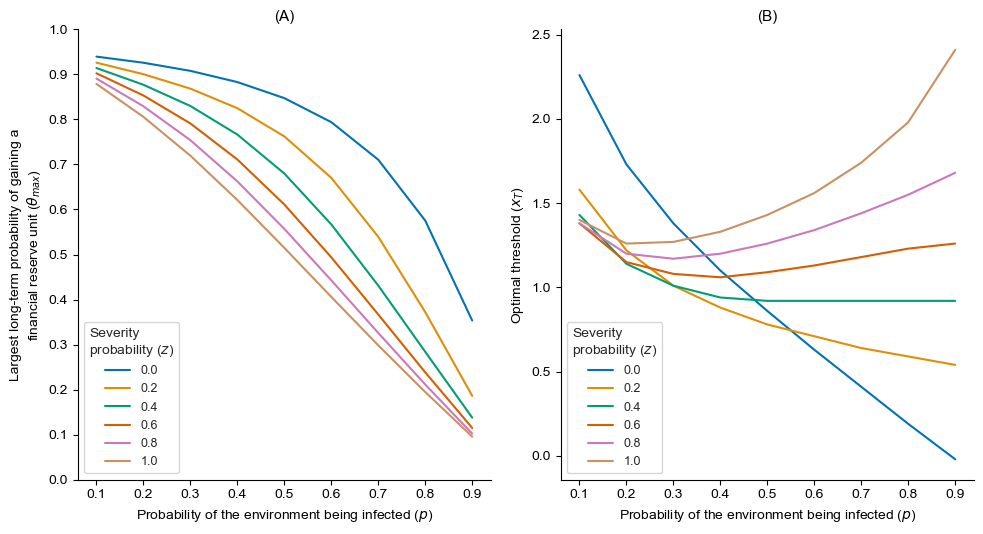

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5.5))
sns.set_theme(style='white', rc={'axes.titlesize': 11, 'axes.labelsize': 10, 'xtick.labelsize': 9, 'ytick.labelsize': 9})

sns.lineplot(data=df_best_pm, x='p', y='theta_max', hue='z', palette='colorblind', ax=axes[0]
).set(ylabel='Largest long-term probability of gaining a\nfinancial reserve unit ($\\theta_{max}$)', yticks=np.arange(0, 1.1, 0.1), title='(A)')

sns.lineplot(data=df_best_pm, x='p', y='threshold', hue='z', palette='colorblind', ax=axes[1]
).set(ylabel='Optimal threshold ($x_T$)', title='(B)')


### CUSTOMISATIONS ###
for ax in axes:
    ax.set_xlabel('Probability of the environment being infected ($p$)')
    ax.legend(title='Severity\nprobability ($z$)', fontsize=9, title_fontsize=10)

    # Hide spines
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

# Extended Severity Model ($u, \lambda$)

In [5]:
### LISTS TO STORE DICTIONARIES ###
pm = []      # List to store dictionaries of each parameter
best_pm = []   # List to store best parameters for every p value


### PARAMETERS ###
Smean=0; Svar=1; Sstd=math.sqrt(Svar)       # Safe environment
Imean=1.5; Ivar=1; Istd=math.sqrt(Ivar)     # Infected environment
delta=0.05                                  # Background mortatility (delta)
l = 0.85                                    # Probability of survival given environment is infected (lambda)
u = 0.01                                    # Unlucky probability (u)

# Probability that the environment is infected (p)
p_range=np.arange(0.1, 1, 0.1).tolist()
p_list=[round(p, 2) for p in p_range]

# Threshold Range (within three standard deviations to get 99.73% of all values) 
Slower = Smean - (3 * Sstd)
Iupper = Imean + (3 * Istd)
threshold_range=np.arange(Slower, Iupper+0.01, 0.01).tolist()
thresholds=[round(t, 2) for t in threshold_range]

iteration = -1  # Row index counter

### ITERATION OVER EVERY PROBABILITY OF THE ENVIRONMENT BEING INFECTED (p) ###
for p in p_list:
    theta_max = best_threshold = 0
    bp = {'index' : iteration, 'p' : p, 'theta_max' : theta_max, 'threshold' : best_threshold}
    
    ### ITERATING OVER EVERY THRESHOLD ###
    for threshold in thresholds:
        iteration = iteration + 1
        
        ### PROBABILITY AREAS ###
        # Calculate z-score for each environment distribution
        Sz = stats.NormalDist(Smean, Sstd).zscore(threshold)
        Iz = stats.NormalDist(Imean, Istd).zscore(threshold)

        # Calculate probability from z-score based on threshold
        Sprob = norm.cdf(Sz)
        Iprob = norm.cdf(Iz)

        # Calculate the specific area of the distributions scaled to the probability of the environment being infected
        p_iw = Iprob * p
        p_ih = (1 - Iprob) * p
        p_sh = (1 - Sprob) * (1 - p)
        p_sw = Sprob * (1 - p)

        ### SHORT-TERM PARAMETERS ###
        a = (1-delta) * ((p_iw * l) + (p_ih * u * l))       # Probability of losing a reserve
        b = (1-delta) * p_sw                                # Probability of gaining a reserve
        c = (1-delta) * (p_sh + (p_ih * (1 - u)))           # Probability of remaining at the same reserve level
        death = 1 - a - b - c                               # Probability of death while trying to gain a reserve

        ### LONG-TERM PROBABILITY (theta) ###
        # Parameters for quadratic formuala
        qf_a = float(a)
        qf_b = float(c - 1)
        qf_c = float(b)

        # Calculate theta
        theta = (-(qf_b) - math.sqrt((pow(qf_b, 2) - (4 * qf_a * qf_c)))) / (2 * qf_a)

        ### DICTIONARY OF PARAMETERS ###
        pm.append(
            {
                'p' : p,
                'threshold' : threshold,
                'a' : a, 'b' : b, 'c' : c,      # Short-term probability
                'theta' : theta,                # Long-term probability
                'd' : death,                    # Residual death
                'p_iw' : p_iw, 'p_ih' : p_ih,
                'p_sw' : p_sw, 'p_sh' : p_sh
            }
        )
        
        # Identifying the threshold with the largest long-term probability of gaining a financial reserve unit (theta)
        if theta > bp['theta_max']:
            bp['index'] = iteration
            bp['p'] = p
            bp['theta_max'] = theta
            bp['threshold'] = threshold
            bp['a'] = a
            bp['b'] = b
            bp['c'] = c
    
    ### SAVE THE BEST PARAMETERS FOR EVERY p ###
    best_pm.append(bp)

## DataFrames

In [6]:
parameters=pd.DataFrame(pm).astype({'p' : 'category'})
best_parameters = pd.DataFrame(best_pm).astype({'p' : 'category'})

In [7]:
best_parameters.drop('index', axis=1)

,p,theta_max,threshold,a,b,c
0,0.1,0.930016,1.54,0.042054,0.802178,0.098347
1,0.2,0.909819,1.13,0.058485,0.661779,0.219415
2,0.3,0.886015,0.89,0.067399,0.540823,0.329884
3,0.4,0.855887,0.71,0.071905,0.433854,0.431552
4,0.5,0.815586,0.55,0.072411,0.336699,0.528112
5,0.6,0.758721,0.41,0.070969,0.250457,0.616051
6,0.7,0.674023,0.27,0.066844,0.172830,0.698531
7,0.8,0.541499,0.13,0.061041,0.104826,0.773361
8,0.9,0.328984,-0.01,0.054409,0.047121,0.838868


## Figure 5: Extended severity model

**(A)** Largest long-term probability of eventually gaining a reserve unit ($\theta_{max}$) across increasing probabilities of environmental infection ($p$).

**(B)** Optimal threshold ($x_T$) across increasing probabilities of environmental infection ($p$).

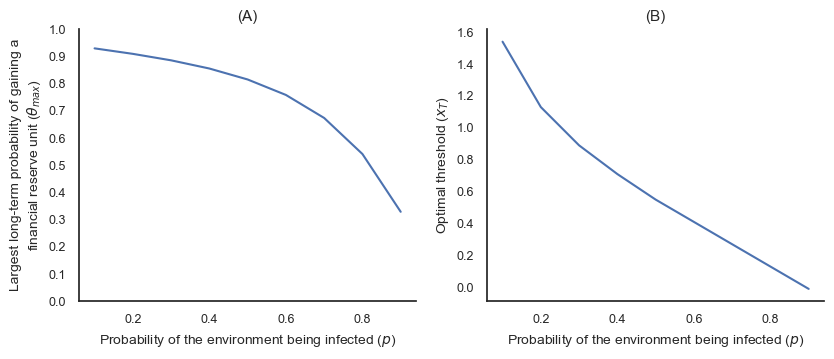

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.75))
sns.set_theme(style='white', rc={'axes.titlesize': 11, 'axes.labelsize': 10, 'xtick.labelsize': 9, 'ytick.labelsize': 9})
sns.set_palette("colorblind")

sns.lineplot(data=best_parameters, x='p', y='theta_max', ax=axes[0]
).set(ylabel='Largest long-term probability of gaining a\nfinancial reserve unit ($\\theta_{max}$)', yticks=np.arange(0, 1.1, 0.1), title='(A)')

sns.lineplot(data=best_parameters, x='p', y='threshold', ax=axes[1]
).set(ylabel='Optimal threshold ($x_T$)', title='(B)')


### CUSTOMISATIONS ###
for ax in axes:
    ax.set_xlabel('Probability of the environment being infected ($p$)')

    # Hide spines
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

## Figure 6: Thresholds, $\theta_{max}$ across $p$

Relationship between optimal threshold ($x_T$) and the largest long-term probability of eventually gaining a reserve unit ($\theta_{max}$) styled by the probability of the environment being infected ($p$)

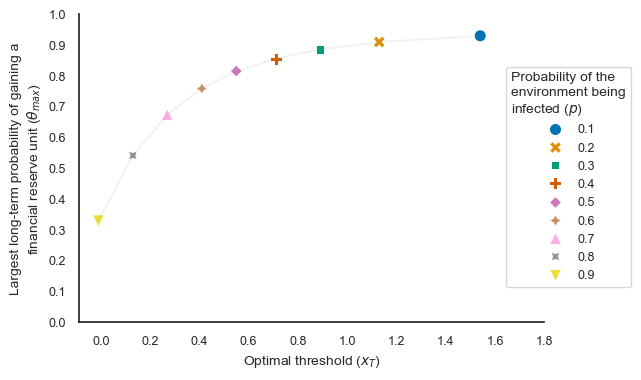

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.set_theme(style='white', rc={'axes.titlesize': 11, 'axes.labelsize': 10, 'xtick.labelsize': 9, 'ytick.labelsize': 9})
sns.set_palette("colorblind")

sns.lineplot(data=best_parameters, x='threshold', y='theta_max', color='grey', alpha=0.1, ax=ax)
sns.scatterplot(data=best_parameters, x='threshold', y='theta_max', style='p', hue='p', s=75, ax=ax)

### CUSTOMISATIONS ###
ax.set_xlabel('Optimal threshold ($x_T$)')
ax.set_ylabel('Largest long-term probability of gaining a\nfinancial reserve unit ($\\theta_{max}$)')
ax.set_xticks(np.arange(0, 2, 0.2))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.legend(title='Probability of the\nenvironment being\ninfected ($p$)', fontsize=9, title_fontsize=10, bbox_to_anchor=(1.2, 0.85))

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

## Figure 7: Short-term probabilities

Short-term probabilities of gaining a reserve unit (green), losing a reserve unit (red), and no change to reserves (blue) across infection probabilities ($p$).

In [10]:
cb=sns.color_palette('colorblind')
cb

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

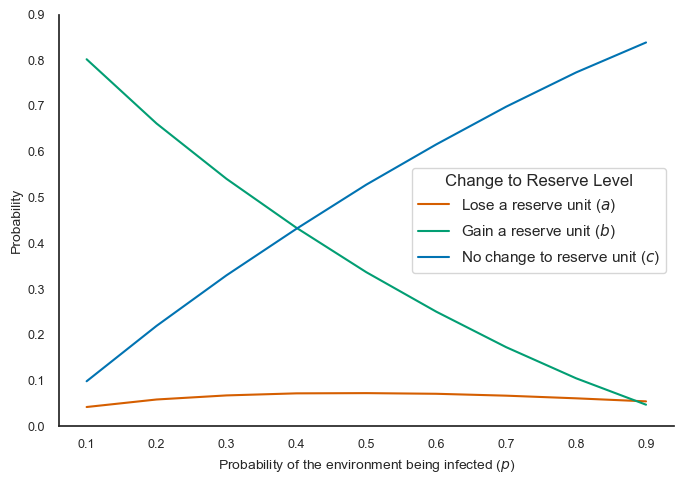

In [11]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.set_theme(style='white', rc={'axes.titlesize': 11, 'axes.labelsize': 10, 'xtick.labelsize': 9, 'ytick.labelsize': 9})
sns.set_palette("colorblind")

sns.lineplot(data=best_parameters, x='p', y='a', color=cb[3], label='Lose a reserve unit ($a$)', ax=ax)
sns.lineplot(data=best_parameters, x='p', y='b', color=cb[2], label='Gain a reserve unit ($b$)', ax=ax)
sns.lineplot(data=best_parameters, x='p', y='c', color=cb[0], label='No change to reserve unit ($c$)', ax=ax)

# Customisations
ax.set_ylabel('Probability')
ax.set_yticks(np.arange(0, 1, 0.1))
ax.legend(title='Change to Reserve Level')
ax.set_xlabel('Probability of the environment being infected ($p$)')

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()

## Figure 8: Short-term probability of losing a financial reserve unit

Magnified view of the short-term probability of losing a financial reserve unit (red) across infection probabilities ($p$)

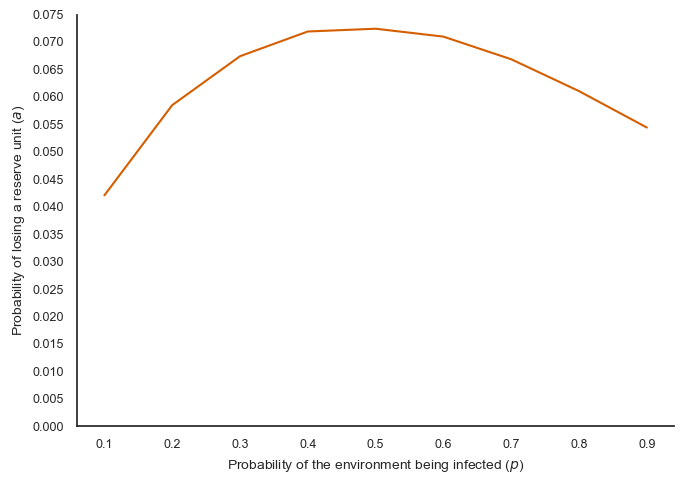

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.set_theme(style='white', rc={'axes.titlesize': 11, 'axes.labelsize': 10, 'xtick.labelsize': 9, 'ytick.labelsize': 9})
sns.set_palette("colorblind")

sns.lineplot(data=best_parameters, x='p', y='a', color=cb[3], ax=ax
).set(xlabel='Probability of the environment being infected ($p$)', ylabel='Probability of losing a reserve unit ($a$)', yticks=np.arange(0, 0.08, 0.005))

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()

## Background Mortality

In [13]:
### LISTS TO STORE DICTIONARIES ###
delta_pm = []         # List to store dictionaries of each parameter
delta_best_pm = []      # List to store best parameters for every p value


### PARAMETERS ###
Smean=0; Svar=1; Sstd=math.sqrt(Svar)       # Safe environment
Imean=1.5; Ivar=1; Istd=math.sqrt(Ivar)     # Infected environment
l = 0.85                                    # Probability of survival given environment is infected 
u=0.01                                      # Unlucky probability

# Background mortality
delta_range=np.arange(0, 0.11, 0.05).tolist()
delta_list=[round(d, 2) for d in delta_range]

# Background probability that the environment is infected
p_range=np.arange(0.1, 1, 0.1).tolist()
p_list=[round(p, 2) for p in p_range]

# Threshold Range (within three standard deviations to get 99.73% of all values) 
Slower = Smean - (3 * Sstd)
Iupper = Imean + (3 * Istd)
threshold_range=np.arange(Slower, Iupper+0.01, 0.01).tolist()
thresholds=[round(t, 2) for t in threshold_range]

iteration = -1  # Row index counter

### ITERATION OVER EVERY BACKGROUND MORTALITY (delta) VALUE ###
for delta in delta_list:
    
    ### ITERATION OVER EVERY PROBABILITY OF THE ENVIRONMENT BEING INFECTED (p) ###
    for p in p_list:
        theta_max = best_threshold = 0
        bp = {'index' : iteration, 'delta' : delta, 'p' : p, 'theta_max' : theta_max, 'threshold' : best_threshold}
        
        ### ITERATING OVER EVERY THRESHOLD ###
        for threshold in thresholds:
            iteration = iteration + 1
            
            ### PROBABILITY AREAS ###
            # Calculate z-score for each environment distribution
            Sz = stats.NormalDist(Smean, Sstd).zscore(threshold)
            Iz = stats.NormalDist(Imean, Istd).zscore(threshold)

            # Calculate probability from z-score based on threshold
            Sprob = norm.cdf(Sz)
            Iprob = norm.cdf(Iz)

            # Calculate specific area of the distributions scaled to the probablity of infected
            p_iw = Iprob * p                    # red
            p_ih = (1 - Iprob) * p              # purple
            p_sh = (1 - Sprob) * (1 - p)        # orange
            p_sw = Sprob * (1 - p)              # green

            ### SHORT-TERM PARAMETERS ###
            a = (1-delta) * ((p_iw * l) + (p_ih * u * l))       # Probability of losing a reserve
            b = (1-delta) * p_sw                                # Probability of gaining a reserve
            c = (1-delta) * (p_sh + (p_ih * (1 - u)))           # Probability of remaining at the same reserve level
            death = 1 - a - b - c                               # Probability of death while trying to gain a reserve

            ### LONG-TERM PROBABILITY (theta) ###
            # Parameters for quadratic formuala
            qf_a = float(a)
            qf_b = float(c - 1)
            qf_c = float(b)

            # Calculate theta
            theta = (-(qf_b) - math.sqrt((pow(qf_b, 2) - (4 * qf_a * qf_c)))) / (2 * qf_a)

            ### DICTIONARY OF PARAMETERS ###
            delta_pm.append(
                {
                    'delta' : delta,
                    'p' : p,
                    'threshold' : threshold,
                    'a' : a, 'b' : b, 'c' : c,      # Short-term probability
                    'g' : b + c, 'w' : a + c,       # Combined short-term probabilties
                    'theta' : theta,                # Long-term probability
                    'd' : death,                    # Residual death
                    'p_iw' : p_iw, 'p_ih' : p_ih,
                    'p_sw' : p_sw, 'p_sh' : p_sh
                }
            )
            
            # Identifying the threshold with the largest long-term probability of gaining a financial reserve unit (theta)
            if theta > bp['theta_max']:
                bp['index'] = iteration
                bp['delta'] = delta
                bp['p'] = p
                bp['theta_max'] = theta
                bp['threshold'] = threshold
                bp['a'] = a
                bp['b'] = b
                bp['c'] = c
        
        ### SAVE THE BEST PARAMETERS FOR EVERY p ###
        delta_best_pm.append(bp)

### DataFrames

In [14]:
delta_parameters = pd.DataFrame(delta_pm).astype({'p' : 'category', 'delta' : 'category'})
delta_best_parameters = pd.DataFrame(delta_best_pm).astype({'p' : 'category', 'delta' : 'category'})    # For each p in each delta

### Figure 9: Background mortality ($\delta$)

**(A)** Largest long-term probability of eventually gaining a reserve unit ($\theta_{max}$) across infection probabilities ($p$) when background mortality ($\delta$) is 0 (blue), 0.05 (orange) and 0.1 (green).

**(B)** Optimal threshold ($x_T$) across infection probabilities ($p$) when background mortality ($\delta$) is 0 (blue), 0.05 (orange) and 0.1 (green).

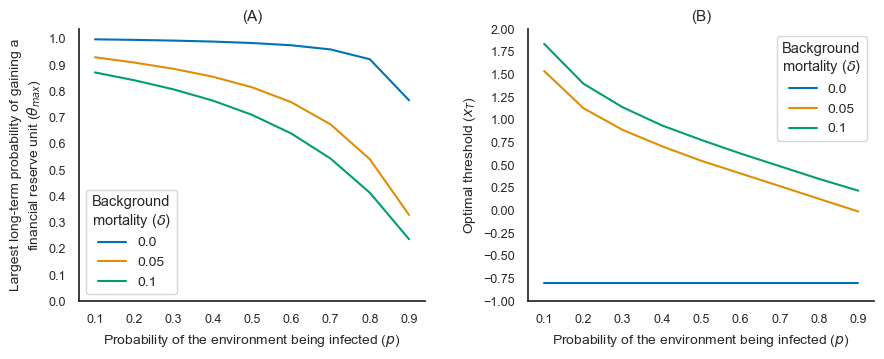

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.75))
sns.set_theme(style='white', rc={'axes.titlesize': 11, 'axes.labelsize': 10, 'xtick.labelsize': 9, 'ytick.labelsize': 9})
sns.set_palette("colorblind")

df=delta_best_parameters


sns.lineplot(data=df, x='p', y='theta_max', hue='delta', palette='colorblind', ax=axes[0]
).set(ylabel='Largest long-term probability of gaining a\nfinancial reserve unit ($\\theta_{max}$)', yticks=np.arange(0, 1.1, 0.1), title='(A)')

sns.lineplot(data=df, x='p', y='threshold', hue='delta', palette='colorblind', ax=axes[1]
).set(ylabel='Optimal threshold ($x_T$)', yticks=np.arange(-1, 2.2, 0.25), title='(B)')


### CUSTOMISATIONS ###
for ax in axes:
    ax.set_xlabel('Probability of the environment being infected ($p$)')
    ax.legend(title='Background\nmortality ($\delta$)', fontsize=10, title_fontsize=10.5,)

    # Hide spines
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

## Unlucky Probability

In [16]:
### LISTS TO STORE DICTIONARIES ###
unlucky_pm = []       # List to store dictionaries of each parameter
unlucky_best_pm = []    # List to store best parameters for every p value

### PARAMETERS ###
Smean=0; Svar=1; Sstd=math.sqrt(Svar)       # Safe environment
Imean=1.5; Ivar=1; Istd=math.sqrt(Ivar)     # Infected environment
l = 0.85                                    # Probability of survival given environment is infected 
delta=0.05                                  # Background mortality

# Unlucky parameter
unlucky_list=[0, 0.05, 0.1, 1]

# Background probability that the environment is infected
p_range=np.arange(0.1, 1, 0.1).tolist()
p_list=[round(p, 2) for p in p_range]

# Threshold Range (within three standard deviations to get 99.73% of all values) 
Slower = Smean - (3 * Sstd)
Iupper = Imean + (3 * Istd)
threshold_range=np.arange(Slower, Iupper+0.01, 0.01).tolist()
thresholds=[round(t, 2) for t in threshold_range]

iteration = -1  # Row index counter

### ITERATION OVER EVERY UNLUCKY PROBABILITY (u) ###
for u in unlucky_list:
    
### ITERATION OVER EVERY PROBABILITY OF THE ENVIRONMENT BEING INFECTED(p) ###
    for p in p_list:
        theta_max = best_threshold = 0
        bp = {'index' : iteration, 'unlucky' : u, 'p' : p, 'theta_max' : theta_max, 'threshold' : best_threshold}
        
        ### ITERATING OVER EVERY THRESHOLD ###
        for threshold in thresholds:
            iteration = iteration + 1
            
            ### PROBABILITY AREAS ###
            # Calculate z-score for each environment distribution
            Sz = stats.NormalDist(Smean, Sstd).zscore(threshold)
            Iz = stats.NormalDist(Imean, Istd).zscore(threshold)

            # Calculate probability from z-score based on threshold
            Sprob = norm.cdf(Sz)
            Iprob = norm.cdf(Iz)

            # Calculate the specific area of the distributions scaled to the probability of the environment being infected
            p_iw = Iprob * p                    # red
            p_ih = (1 - Iprob) * p              # purple
            p_sh = (1 - Sprob) * (1 - p)        # orange
            p_sw = Sprob * (1 - p)              # green

            ### SHORT-TERM PARAMETERS ###
            a = (1-delta) * ((p_iw * l) + (p_ih * u * l))       # Probability of losing a reserve
            b = (1-delta) * p_sw                                # Probability of gaining a reserve
            c = (1-delta) * (p_sh + (p_ih * (1 - u)))           # Probability of remaining at the same reserve level
            death = 1 - a - b - c                               # Probability of death while trying to gain a reserve

            ### LONG-TERM PROBABILITY (theta) ###
            # Parameters for quadratic formula
            qf_a = float(a)
            qf_b = float(c - 1)
            qf_c = float(b)

            # Calculate theta
            theta = (-(qf_b) - math.sqrt((pow(qf_b, 2) - (4 * qf_a * qf_c)))) / (2 * qf_a)

            ### DICTIONARY OF PARAMETERS ###
            unlucky_pm.append(
                {
                    'unlucky' : u,
                    'p' : p,
                    'threshold' : threshold,
                    'theta' : theta,                # Long-term probability
                    'd' : death,                    # Residual death
                    'p_iw' : p_iw, 'p_ih' : p_ih,
                    'p_sw' : p_sw, 'p_sh' : p_sh
                }
            )
            
            # Identifying the threshold with the largest long-term probability of gaining a financial reserve unit (theta)
            if theta > bp['theta_max']:
                bp['index'] = iteration
                bp['unlucky'] = u
                bp['p'] = p
                bp['theta_max'] = theta
                bp['threshold'] = threshold
                bp['a'] = a
                bp['b'] = b
                bp['c'] = c
        
        ### SAVE THE BEST PARAMETERS FOR EVERY p ###
        unlucky_best_pm.append(bp)

### DataFrames

In [17]:
unlucky_parameters = pd.DataFrame(unlucky_pm).astype({'p' : 'category', 'unlucky' : 'category'})
unlucky_best_parameters = pd.DataFrame(unlucky_best_pm).astype({'p' : 'category', 'unlucky' : 'category'})    # For each p in each delta

### Figure 10: Unlucky probability ($u$)

**(A)** Largest long-term probability of eventually gaining a reserve unit ($\theta_{max}$) across infection probabilities ($p$) when the unlucky probability ($u$) is 0 (blue), 0.05 (yellow), 0.1 (green) and 1.0 (orange). 

**(B)** Optimal threshold ($x_T$) across infection probabilities ($p$) when the unlucky probability ($u$) is 0 (blue), 0.05 (yellow), 0.1 (green) and 1.0 (orange).

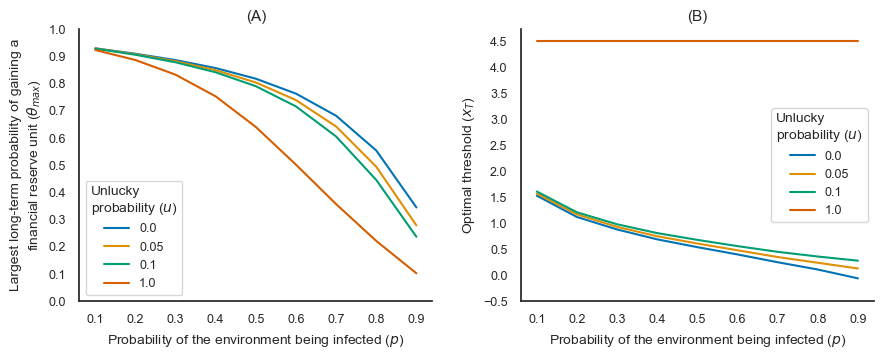

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.75))
sns.set_theme(style='white', rc={'axes.titlesize': 11, 'axes.labelsize': 10, 'xtick.labelsize': 9, 'ytick.labelsize': 9})
sns.set_palette("colorblind")

df=unlucky_best_parameters

sns.lineplot(data=df, x='p', y='theta_max', hue='unlucky', palette='colorblind', ax=axes[0]
).set(ylabel='Largest long-term probability of gaining a\nfinancial reserve unit ($\\theta_{max}$)', yticks=np.arange(0, 1.1, 0.1), title='(A)')

sns.lineplot(data=df, x='p', y='threshold', hue='unlucky', palette='colorblind', ax=axes[1]
).set(ylabel='Optimal threshold ($x_T$)', yticks=np.arange(-0.5, 4.6, 0.5), title='(B)')


### CUSTOMISATIONS ###
for ax in axes:
    ax.set_xlabel('Probability of the environment being infected ($p$)')
    ax.legend(title='Unlucky\nprobability ($u$)', fontsize=9, title_fontsize=10)

    # Hide spines
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

# Checking with the Signal Detection Theory Equation

In [19]:
### LISTS TO STORE DICTIONARIES ###
best_pm = []          # List to store best parameters for every p value

### PARAMETERS ###
Smean=0; Svar=1; Sstd=math.sqrt(Svar)       # Safe environment
Imean=1.5; Ivar=1; Istd=math.sqrt(Ivar)     # Infected environment
delta=0.05                                  # Background mortatility 
l = 0.85                                    # Probability of survival given environment is infected 
u = 0.01                                    # Unlucky probability

# Background probability that the environment is infected
p_range=np.arange(0.1, 1, 0.025).tolist()
p_list=[round(p, 2) for p in p_range]

# Threshold Range (within three standard deviations to get 99.73% of all values) 
Slower = Smean - (3 * Sstd)
Iupper = Imean + (3 * Istd)
threshold_range=np.arange(Slower, Iupper+0.01, 0.01).tolist()
thresholds=[round(t, 2) for t in threshold_range]

### ITERATION OVER EVERY PROBABILITY OF THE ENVIRONMENT BEING INFECTED (p) ###
for p in p_list:
    theta_max = best_threshold = 0
    bp = {'p' : p, 'theta_max' : theta_max, 'threshold' : best_threshold}
    
    ### ITERATING OVER EVERY THRESHOLD ###
    for threshold in thresholds:
        iteration = iteration + 1
        
        ### PROBABILITY AREAS ###
        # Calculate z-score for each environment distribution
        Sz = stats.NormalDist(Smean, Sstd).zscore(threshold)
        Iz = stats.NormalDist(Imean, Istd).zscore(threshold)

        # Calculate probability from z-score based on threshold
        Sprob = norm.cdf(Sz)
        Iprob = norm.cdf(Iz)

        # Calculate the specific area of the distributions scaled to the probability of the environment being infected
        p_iw = Iprob * p                    # red
        p_ih = (1 - Iprob) * p              # purple
        p_sh = (1 - Sprob) * (1 - p)        # orange
        p_sw = Sprob * (1 - p)              # green

        ### SHORT-TERM PARAMETERS ###
        a = (1-delta) * ((p_iw * l) + (p_ih * u * l))       # Probability of losing a reserve
        b = (1-delta) * p_sw                                # Probability of gaining a reserve
        c = (1-delta) * (p_sh + (p_ih * (1 - u)))           # Probability of remaining at the same reserve level
        death = 1 - a - b - c                               # Probability of death while trying to gain a reserve

        ### LONG-TERM PROBABILITY (theta) ###
        # Parameters for quadratic formula
        qf_a = float(a)
        qf_b = float(c - 1)
        qf_c = float(b)

        # Calculate theta
        theta = (-(qf_b) - math.sqrt((pow(qf_b, 2) - (4 * qf_a * qf_c)))) / (2 * qf_a)
        
        # Identifying the threshold with the largest long-term probability of gaining a financial reserve unit (theta)
        if theta > bp['theta_max']:
            bp['p'] = p
            bp['theta_max'] = theta
            bp['threshold'] = threshold
    
    ### SAVE THE BEST PARAMETERS FOR EVERY p ###
    best_pm.append(bp)

## DataFrames

In [20]:
best_parameters=pd.DataFrame(best_pm)
best_parameters

,p,theta_max,threshold
0,0.10,0.930016,1.54
1,0.12,0.926141,1.43
2,0.15,0.920210,1.30
3,0.17,0.916142,1.23
4,0.20,0.909819,1.13
5,0.22,0.905427,1.07
6,0.25,0.898525,1.00
7,0.27,0.893685,0.95
8,0.30,0.886015,0.89
9,0.32,0.880595,0.85


## Applying the SDT Equation
From page 18 of McNamara & Trimmer (2019):

$$\frac{(1-p)}{p} \times \frac{(V_{SW}-V_{SH})}{(V_{IH}-V_{IW})}$$

$$= \frac{(1-p)}{p} \times \frac{(\alpha - \alpha\theta^2)}{\alpha\theta^2 - 0}$$

$$= \frac{(1-p)}{p} \times \frac{\alpha (1 - \theta^2)}{\alpha\theta^2}$$

$$= \frac{(1-p)}{p} \times \frac{(1 - \theta^2)}{\theta^2}$$

For **SDT** equation: Use the $\theta_{max}$ values from $p=0.2$ for *all* $p$ values (*fixed*)

For **SDDT** equation: Use the $\theta_{max}$ values associated with each $p$ value (*variable*)

In [21]:
sdt_eq = best_parameters.copy().astype({'p' : float})

# SDT - Fixed theta (taken from p = 0.2)
fixed_theta = sdt_eq.loc[sdt_eq['p'] == 0.2, 'theta_max'].item()

sdt_eq["SDT-threshold"] = (
    ((1 - sdt_eq['p']) / sdt_eq['p']) *
    ((1 - (fixed_theta ** 2)) / (fixed_theta ** 2))
)

# SDDT - Variable theta
sdt_eq["SDDT-threshold"] = (
    ((1 - sdt_eq['p']) / sdt_eq['p']) *
    ((1 - (sdt_eq['theta_max'] ** 2)) / (sdt_eq['theta_max'] ** 2))
)

# Rearrange columns
sdt_eq.insert(3, "SDT-threshold", sdt_eq.pop("SDT-threshold"))
sdt_eq.insert(4, "SDDT-threshold", sdt_eq.pop("SDDT-threshold"))

sdt_eq.head()

,p,theta_max,threshold,SDT-threshold,SDDT-threshold
0,0.10,0.930016,1.54,1.872567,1.405476
1,0.12,0.926141,1.43,1.525796,1.216299
2,0.15,0.920210,1.30,1.179024,1.025300
3,0.17,0.916142,1.23,1.015837,0.934702
4,0.20,0.909819,1.13,0.832252,0.832252


## SDT vs SDDT vs Extended Severity Model

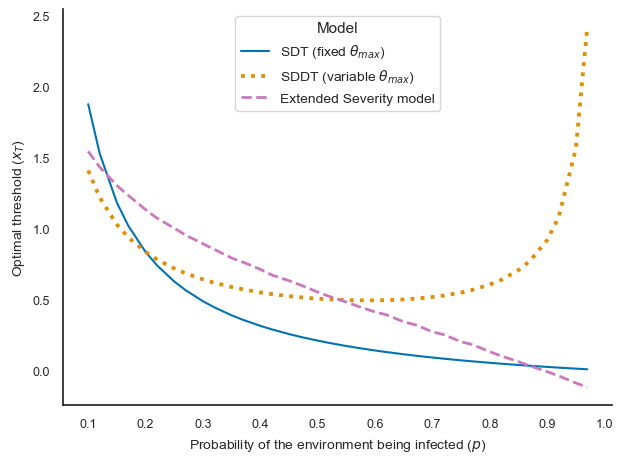

In [22]:
fig, ax = plt.subplots()
sns.set_theme(style='white', rc={'axes.titlesize': 11, 'axes.labelsize': 10, 'xtick.labelsize': 9, 'ytick.labelsize': 9})
sns.set_palette("colorblind")

palette = sns.color_palette("colorblind")

# Plots
sns.lineplot(data=sdt_eq, x='p', y="SDT-threshold", label='SDT (fixed $\\theta_{max}$)', color=palette[0])
sns.lineplot(data=sdt_eq, x='p', y="SDDT-threshold", label='SDDT (variable $\\theta_{max}$)', color=palette[1], linestyle='dotted', lw=2.75)
sns.lineplot(data=sdt_eq, x='p', y="threshold", label='Extended Severity model', color=palette[4], linestyle='--', lw=2)

# Customisations
ax.set_xlabel('Probability of the environment being infected ($p$)')
ax.set_xticks(np.arange(0.1, 1.1, 0.1))
ax.set_ylabel('Optimal threshold ($x_T$)')
ax.legend(fontsize=10, title='Model', title_fontsize=11, loc='upper center')

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()

## Figure 11: SDT vs SDDT

Comparing optimal thresholds ($x_T$) resulting from the Signal Detection Theory (SDT; blue, solid) and the State-Dependent Detection Theory (SDDT; orange, dotted) across increasing probabilities of the environment being infected ($p$).

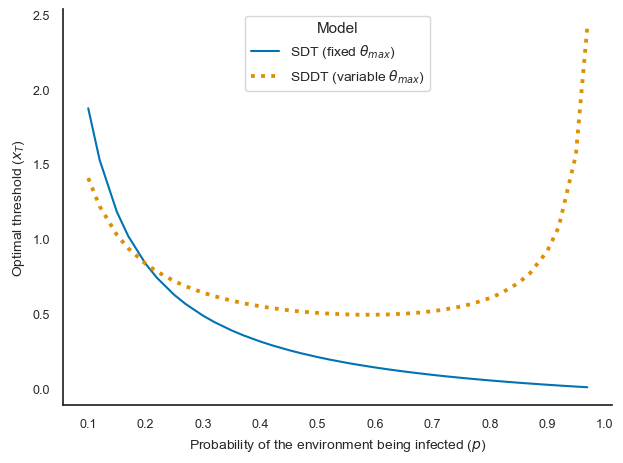

In [23]:
fig, ax = plt.subplots()
sns.set_theme(style='white', rc={'axes.titlesize': 11, 'axes.labelsize': 10, 'xtick.labelsize': 9, 'ytick.labelsize': 9})
sns.set_palette("colorblind")

palette = sns.color_palette("colorblind")

# Plots
sns.lineplot(data=sdt_eq, x='p', y="SDT-threshold", label='SDT (fixed $\\theta_{max}$)', color=palette[0])
sns.lineplot(data=sdt_eq, x='p', y="SDDT-threshold", label='SDDT (variable $\\theta_{max}$)', color=palette[1], linestyle='dotted', lw=2.75)

# Customisations
ax.set_xlabel('Probability of the environment being infected ($p$)')
ax.set_xticks(np.arange(0.1, 1.1, 0.1))
ax.set_ylabel('Optimal threshold ($x_T$)')
ax.legend(fontsize=10, title='Model', title_fontsize=11, loc='upper center')

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()

## Figure 12: SDT vs Extended Severity Model

Comparing optimal thresholds ($x_T$) resulting from the Extended Severity Model (pink, dashed) with **(A)** the Signal Detection Theory (SDT; blue, solid) and **(B)** the State-Dependent Detection Theory (SDDT; orange, dotted).

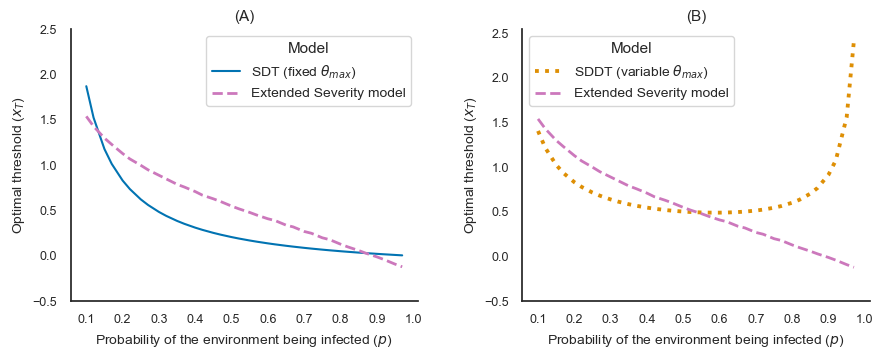

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.75))
sns.set_theme(style='white', rc={'axes.titlesize': 11, 'axes.labelsize': 10, 'xtick.labelsize': 9, 'ytick.labelsize': 9})
sns.set_palette("colorblind")

palette = sns.color_palette("colorblind")

# Plots
sns.lineplot(data=sdt_eq, x='p', y="SDT-threshold", label='SDT (fixed $\\theta_{max}$)', color=palette[0], ax=axes[0])
sns.lineplot(data=sdt_eq, x='p', y="threshold", label='Extended Severity model', color=palette[4], linestyle='--', lw=2, ax=axes[0])
axes[0].set(title='(A)')

sns.lineplot(data=sdt_eq, x='p', y="SDDT-threshold", label='SDDT (variable $\\theta_{max}$)', color=palette[1], linestyle='dotted', lw=2.75, ax=axes[1])
sns.lineplot(data=sdt_eq, x='p', y="threshold", label='Extended Severity model', color=palette[4], linestyle='--', lw=2, ax=axes[1])
axes[1].set(title='(B)')


# Customisations
for ax in axes.flat:
    ax.set_xlabel('Probability of the environment being infected ($p$)')
    ax.set_xticks(np.arange(0.1, 1.1, 0.1))
    ax.set_ylabel('Optimal threshold ($x_T$)')
    ax.set_yticks(np.arange(-0.5, 2.6, 0.5))
    ax.legend(fontsize=10, title='Model', title_fontsize=11)

    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)